# Homework 04 - Applied ML

## Data Description

Soccer players (N = 2053) and all referees (N = 3147) that these players played under in their professional career. The data contains:

* the number of matches, players and referees encountered each other
* the number of red cards(dependent variable), given to a player by a particular referee (throughout all matches the two encountered each other)
* Player photos were available from the source for 1586 out of 2053 players
* Players’ skin tone was coded by two independent raters, 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value
* implicit bias scores for each referee country, race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations
* Explicit bias scores for each referee country, racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks.

Let's first import the necessary libraries so that we can read the dataset.

In [1]:
import pandas as pd
import numpy as np

Now let's get ahold of the data we will be working with! We will first

In [2]:
soccer_data = pd.read_csv('CrowdstormingDataJuly1st.csv')
soccer_data.shape

(146028, 28)

That's a lot of data ;) Instead of using `head()`, let's print the first 14 columns and the next 14 seperately.

In [3]:
soccer_data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [4]:
soccer_data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


For a description of each feature check out the file `DATA.md`.

# Data Cleaning

Let's first clean the data a bit. The first thing we can do is drop those players which have no rating for the skin color as we will not be able to do any training with this data or even evaluate our classifier with such entries.

In [5]:
soccer_data_clean = soccer_data[~soccer_data.photoID.isnull()]
soccer_data.shape[0] - soccer_data_clean.shape[0] # number of dropped players

21407

21407 entries have been dropped! Let's just make sure that all `rater1` and `rater2` fields are valid.

In [6]:
print(soccer_data_clean[soccer_data_clean.rater1.isnull()].shape)
soccer_data_clean[soccer_data_clean.rater2.isnull()].shape

(0, 28)


(0, 28)

The given data has an inconvenient structure for our analysis: each row is a _dyad_, which has a single player-referee interaction. This means that if a player has played games with more than 1 referee, that player will have several rows in this dataset. For example, let's look at everyone's favorite googly-eyed German: Mesut Ozil.

In [7]:
soccer_data_clean[(soccer_data_clean.playerShort == "mesut-oezil")][:5]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
26,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1051,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,1,...,0.25,66,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1773,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,2,2,...,0.25,72,28,IRL,0.355498,4078.0,0.000098,0.517225,4238.0,0.000405
2852,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,14,11,...,0.25,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3407,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,0,...,0.25,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


As we can see certain _features_ of a player stay the same, e.g. his name, his height, and his weight. We will also assume that `club` and `leagueCountry` also stays the same during the player's career is done in this dataset (I check with Zlatan Ibrahimovic who has gone between multiple clubs but the only one listed for him was PSG). Some other variables depend on the referee (see table below).

In the first exercise, we would like to predict the skin color of a player given his description and the second exercise asks to "aggregate the referee information grouping by soccer player". Therefore, we will have to perform some careful aggregation with those variables that depend on the referee. The table below describes how we will deal with each feature when performing aggregation. We decided to disregard the referee scores as another [work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) found that country attitude scores do not predict carding by individual referees. Moreover, referees are professionals so it would be surprising such a prediction could be made!

| Feature  | Process  | Reason/Assumption  |
|---|---|---|
| _playerShort_  | Keep first  | Unique for player  |
| _player_  | Keep first  | Unique for player  |
| _club_  | Keep first  | Assuming player stays in same team  |
| _leagueCountry_  | Keep first  | Assumping player stays in same team  |
| _birthday_  | Keep first  | Unique for player  |
| _height_  | Keep first  | Assuming player does not grow or have a significant height increase during a single season.  |
| _weight_  | Keep first  | Assuming player does gain a significant amount of weight during a single season.  |
| _position_  | Keep first  | Assuming players has the same position during a single season.  |
| _games_  | Sum over rows  | Yields total number of games during the 2012/2013 season.  |
| _victories_  | Sum over rows  | Yields total number of victories.   |
| _ties_  | Sum over rows  | Yields total number of ties.  |
| _defeats_  | Sum over rows  | Yields total number of defeats.  |
| _goals_  | Sum over rows  | Yields total number of goals.  |
| _yellowCards_  | Sum over rows  | Yields total number of yellow cards.  |
| _yellowReds_  | Sum over rows  | Yields total number of red cards obtained by two yellow cards.  |
| _redCards_  | Sum over rows  | Yields total number of straight red cards.  |
| _photoID_  | Disregard  | Not needed the photo ID for our analysis.  |
| _rater1_  | Keep first  | Unique for player  |
| _rater2_  | Keep first  | Unique for player  |
| _refNum_  | Disregard  | Purpose of aggregation is to remove "relationship" with a particular referee.   |
| _refCountry_  | Disregard  | Purpose of aggregation is to remove "relationship" with a particular referee.  |
| <em>Alpha\_3</em>  | Disregard  | As it is another representation of the referee's country, we will also disregard this.  |
| _meanIAT_  | Disregard  | Computing weighted average.  |
| _nIAT_  | Disregard  | We do not believe this will help with the classification.  |
| _seIAT_  | Disregard  | We do not believe this will help with the classification.  |
| _meanExp_  | Disregard  | Computing weighted average.  |
| _nExp_  |  Disregard | We do not believe this will help with the classification.  |
| _seExp_  | Disregard  | We do not believe this will help with the classification.  |

First we will create a new DataFrame with `playerShort` as the index and we will sum over the necesary features/columns.

In [8]:
player_groups = soccer_data_clean.groupby("playerShort")
data_agg = player_groups[["games", "victories","ties","defeats","goals","yellowCards","yellowReds","redCards"]].aggregate(np.sum)
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0
aaron-hunt,336,141,73,122,62,42,0,1
aaron-lennon,412,200,97,115,31,11,0,0
aaron-ramsey,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2


Now we will create a weighted sum of the mean implicit (IAT) and explicit (Exp) bias scores. Although such data is describing the referee and not the players, when we also take into the number of cards a certain player received it could give some information on how a player might have been discriminated against.

In [9]:
ref_bias = soccer_data_clean[["playerShort", "games","meanIAT","meanExp"]].groupby("playerShort")
# weighted sum of mean IAT and Exp scores
def weighted_average(group, feature):
    weights = group['games']
    total_games = weights.sum()
    scores = group[feature]
    return (scores * weights).sum() / total_games
data_agg["weightedIAT"] = ref_bias.apply(weighted_average, 'meanIAT')   
data_agg["weightedExp"] = ref_bias.apply(weighted_average, 'meanExp') 
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp
playerShort,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895


We will also create a feature that contains the number of unique referees which gave each card type. Perhaps one referee was really biased towards a certain player.

In [10]:
# count number of non-zero entries, i.e. number of unique referees who have given the card
def num_unique_ref_card(group, card_type):
    ref_card = group[card_type]
    return (ref_card!=0).sum()

# count number of unique referees that have given a card to a particular player
def num_unique_ref(group):
    ref_cards = group['yellowCards']+group['yellowReds']+group['redCards']
    return (ref_cards!=0).sum()

data_agg['uniqueYellow'] = player_groups.apply(num_unique_ref_card, 'yellowCards')
data_agg['uniqueYellowReds'] = player_groups.apply(num_unique_ref_card, 'yellowReds')
data_agg['uniqueReds'] = player_groups.apply(num_unique_ref_card, 'redCards')
data_agg['uniqueRefCards'] = player_groups.apply(num_unique_ref)
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,16,0,0,16
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,29,0,1,29
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,10,0,0,10
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,25,0,1,26
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,8,4,2,13


In [11]:
data_agg.tail()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
zoltan-gera,392,150,96,146,71,44,1,1,0.336001,0.417374,35,1,1,37
zoltan-stieber,142,48,37,57,27,12,0,0,0.336786,0.345085,12,0,0,12
zoumana-camara,395,148,117,130,7,46,2,6,0.338068,0.363993,30,2,6,33
zubikarai,47,14,15,18,0,2,0,2,0.369270,0.590521,2,0,2,4
zurutuza,160,68,39,53,12,22,0,0,0.368915,0.588902,16,0,0,16


Now we need to extract the features of a player that are constant: Name, Height, Weight, Birthday, Position and Skin Color ratings, Club, Country of the League.

In [12]:
def extract_const_feat(group, param):
    return group[param].values[0]

const_feat = ["height","weight","club","leagueCountry","birthday","position","rater1","rater2"]
for feat in const_feat:
    data_agg[feat] = player_groups.apply(extract_const_feat, feat)
data_agg.ix[:5,:14]

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,16,0,0,16
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,29,0,1,29
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,10,0,0,10
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,25,0,1,26
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,8,4,2,13


In [13]:
data_agg.ix[:5,14:]

,height,weight,club,leagueCountry,birthday,position,rater1,rater2
playerShort,,,,,,,,
aaron-hughes,182.0,71.0,Fulham FC,England,08.11.1979,Center Back,0.25,0.00
aaron-hunt,183.0,73.0,Werder Bremen,Germany,04.09.1986,Attacking Midfielder,0.00,0.25
aaron-lennon,165.0,63.0,Tottenham Hotspur,England,16.04.1987,Right Midfielder,0.25,0.25
aaron-ramsey,178.0,76.0,Arsenal FC,England,26.12.1990,Center Midfielder,0.00,0.00
abdelhamid-el-kaoutari,180.0,73.0,Montpellier HSC,France,17.03.1990,Center Back,0.25,0.25


We will use the `birthday` and today's date to compute the age of a player.

In [14]:
from datetime import datetime
def compute_age(player):
    return (datetime.now() - pd.to_datetime(player['birthday'])).days/365
data_agg['age'] = data_agg.apply(compute_age, axis=1)
data_agg.drop('birthday', axis=1, inplace=True)

Finally, we will need to use [_dummy encoding_](https://en.wikiversity.org/wiki/Dummy_variable_(statistics) for those features that are not numeric: `club`, `leagueCountry`, and `position`.

In [15]:
data_agg.dtypes

games                 int64
victories             int64
ties                  int64
defeats               int64
goals                 int64
yellowCards           int64
yellowReds            int64
redCards              int64
weightedIAT         float64
weightedExp         float64
uniqueYellow          int64
uniqueYellowReds      int64
uniqueReds            int64
uniqueRefCards        int64
height              float64
weight              float64
club                 object
leagueCountry        object
position             object
rater1              float64
rater2              float64
age                 float64
dtype: object

Luckily, `pandas` has a function to do this dummy encoding for us ;)

In [16]:
player_data = pd.get_dummies(data_agg)
player_data.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,...,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we need to combine the two skin rating values into a single value corresponding to the skin color of the player; this combination will be done by taking the average of the two. In the exercises that follow, we will stick to binary classification (black or white) rather than multiclass (as their are 5 possible values for rating the skin color). With only two ratings, the uncertainty margin may be too large to allow for precise classification into the five classes. For binary classification, we will assign less than or equal to 0.5 as `white` and greater than 0.5 to `black`.

In [17]:
# Label two different skin colors according to rate average: 0-white, 1-black.
def rate_average_label(group):
    rate_average = (group['rater1'].values[0]+ group['rater2'].values[0])/2
    skin = 0
    if rate_average > 0.5:
        skin = 1
    return skin

#player_data["color_rate"] = player_groups.apply(rate_average) 
player_data["skin_label"] = player_groups.apply(rate_average_label) 
player_data.drop(['rater1','rater2'], axis=1, inplace=True)
player_data.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,...,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,skin_label
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Check if there is any annoying NaN. 

In [18]:
player_data.isnull().any().sum()

2

In [19]:
player_data.shape

(1585, 131)

In [20]:
data_no_nan = player_data.dropna()
data_no_nan.isnull().any().sum()

0

In [21]:
data_no_nan.shape

(1564, 131)

Since there are just 19 data with NaN, we can just drop them in convinience.

# Classification

<em>Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?</em>

## Pure Random Forest (PRF)

First let us train model using RandomForestClassifier. Without cross-validation, we want to know the most important features for the model at first.

In [22]:
from sklearn import ensemble

In [23]:
# random-forest
feature_name = data_no_nan.columns.values.tolist()
n_sample = data_no_nan.shape[0] #1564
n_feature = data_no_nan.shape[1]-1 #130
X = data_no_nan.ix[0::, :(n_feature-1)]
Y = data_no_nan.ix[0::, n_feature]

# Create the random forest object for the fit
forest = ensemble.RandomForestClassifier(n_estimators = 100)
# Fit the training data to the skin labels and create the decision trees
forest = forest.fit(X, Y)

In [24]:
print ("Features sorted by their score:")
importance = forest.feature_importances_
sorted_feature = sorted(zip(map(lambda x: round(x, 4), importance), feature_name), reverse=True)
for f_importance in range(len(sorted_feature)):
    print (sorted_feature[f_importance])

Features sorted by their score:
(0.094100000000000003, 'weightedIAT')
(0.079699999999999993, 'weightedExp')
(0.052900000000000003, 'age')
(0.051400000000000001, 'games')
(0.050599999999999999, 'victories')
(0.0487, 'defeats')
(0.047399999999999998, 'goals')
(0.047199999999999999, 'ties')
(0.046199999999999998, 'weight')
(0.044699999999999997, 'yellowCards')
(0.040599999999999997, 'uniqueYellow')
(0.040300000000000002, 'height')
(0.040000000000000001, 'uniqueRefCards')
(0.026100000000000002, 'leagueCountry_France')
(0.019599999999999999, 'uniqueYellowReds')
(0.018499999999999999, 'redCards')
(0.017299999999999999, 'uniqueReds')
(0.017000000000000001, 'yellowReds')
(0.0114, 'leagueCountry_Germany')
(0.0111, 'position_Center Forward')
(0.010699999999999999, 'club_Olympique Marseille')
(0.0101, 'leagueCountry_Spain')
(0.0077000000000000002, 'leagueCountry_England')
(0.0067999999999999996, 'position_Defensive Midfielder')
(0.0057999999999999996, 'position_Goalkeeper')
(0.0055999999999999999

Since there are 130 features, we just observe first 13 features (10%).

In [25]:
sum_fi = 0
for f_importance in range(13):
    sum_fi += sorted_feature[f_importance][0]
    print("%d. %s (%f)" % (f_importance + 1, sorted_feature[f_importance][1], sorted_feature[f_importance][0]))
print("The feature importance propotion of the top 13: %f" % sum_fi )

1. weightedIAT (0.094100)
2. weightedExp (0.079700)
3. age (0.052900)
4. games (0.051400)
5. victories (0.050600)
6. defeats (0.048700)
7. goals (0.047400)
8. ties (0.047200)
9. weight (0.046200)
10. yellowCards (0.044700)
11. uniqueYellow (0.040600)
12. height (0.040300)
13. uniqueRefCards (0.040000)
The feature importance propotion of the top 13: 0.683800


In [26]:
top_feature = pd.DataFrame(sorted_feature[:13], columns = ['feature_importance', 'feature_name'])

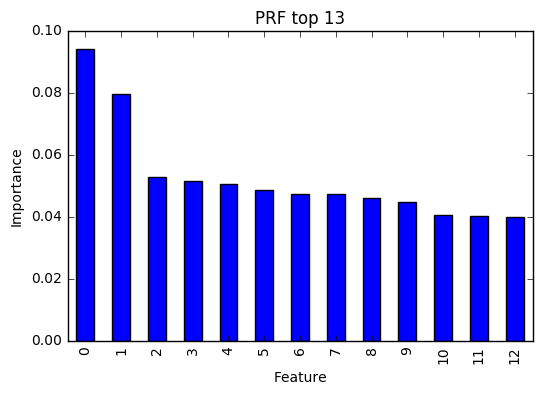

In [27]:
import matplotlib.pyplot as plt
# Plot the feature importances of the forest
plt.figure()
plt.title("PRF top 13")
top_feature['feature_importance'].plot(kind='bar') 
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Random Forest using cross-validation (RFCV)

Divide the data set into training and testing part. Train the model with training set and use this model to make the prediction of testing set. Calculate the difference between predictions and the ture label in testing set.

In [28]:
# cross-validation
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [29]:
# Create the random forest object for the fit
rf = ensemble.RandomForestClassifier(n_estimators = 100)
# Fit the training data to the skin labels and create the decision trees
rf = rf.fit(X_train, Y_train)
# Get predict
rf_predict = rf.predict(X_test)
# calculate accuracy
print(metrics.accuracy_score(Y_test, rf_predict))

0.859335038363


The precision is over 85%, which seems to be pretty good.

In [30]:
# observe first 13 features(10%)
rf_importance = rf.feature_importances_
rf_feature = sorted(zip(map(lambda x: round(x, 4), rf_importance), feature_name), reverse=True)
top_feature = pd.DataFrame(rf_feature[:13], columns = ['feature_importance', 'feature_name'])

In [31]:
sum_fi = 0
for f_importance in range(13):
    sum_fi += rf_feature[f_importance][0]
    print("%d. %s (%f)" % (f_importance + 1, rf_feature[f_importance][1], rf_feature[f_importance][0]))
print("The feature importance propotion of the top 13: %f" % sum_fi )

1. weightedIAT (0.087300)
2. weightedExp (0.073000)
3. age (0.055300)
4. victories (0.054200)
5. games (0.049100)
6. defeats (0.048400)
7. goals (0.045600)
8. ties (0.045400)
9. weight (0.044400)
10. uniqueYellow (0.043900)
11. uniqueRefCards (0.042200)
12. yellowCards (0.040800)
13. height (0.038100)
The feature importance propotion of the top 13: 0.667700


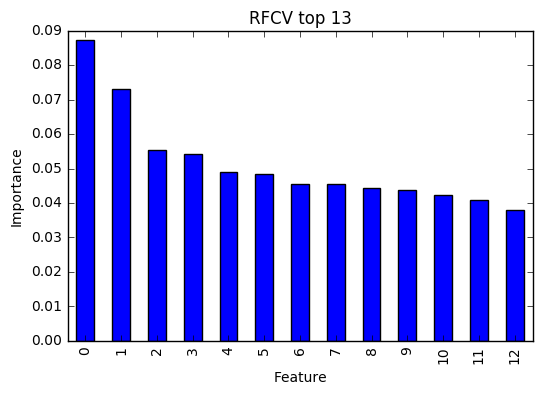

In [32]:
# Plot the feature importances of the forest
plt.figure()
plt.title("RFCV top 13")
top_feature['feature_importance'].plot(kind='bar') 
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Comparing to the pure random forest(PRF), the top 5 of most important features of the random forest using cross-validation(RFCV) are the same: weightedIAT, weightedExp, age, victories, games. The feature importance propotion of these top 13 features are similar: PRF - 0.68, RFCV - 0.67. 

In addition, the result might slightly change if restart to compute the forest, since the forest is built 'randomly', aa well as the data spliting.

## RFCV without Height and Weight (RFCV_HW)

Surprisingly, we once assumed that the 'height' and 'weight' of players are not important to the classification. However, they are at the top 13 of both random forest. What's more, in the RFCV, the importance of 'weight' increase. In order to learn how different parameters affect the model, we drop features 'height' and 'weight' to see the differences.

In [33]:
# RFCV without 'height' and 'weight'
data_selection = data_no_nan.drop('height', axis=1)
data_selection = data_selection.drop('weight', axis=1)
data_selection.shape

(1564, 129)

In [34]:
n_feature_name = data_selection.columns.values.tolist()
n_sample = data_selection.shape[0] #1564
n_feature = data_selection.shape[1]-1 #128
X1 = data_selection.ix[0::, :(n_feature-1)]
Y1 = data_selection.ix[0::, n_feature]

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, random_state=0)

In [35]:
# Create the random forest object for the fit
rf1 = ensemble.RandomForestClassifier(n_estimators = 100)
# Fit the training data to the skin labels and create the decision trees
rf1 = rf1.fit(X1_train, Y1_train)
# Get predict
rf1_predict = rf1.predict(X1_test)
# calculate accuracy
print(metrics.accuracy_score(Y1_test, rf1_predict))

0.854219948849


The difference of accuracy is slight: RFCV - 0.859, RFCV_HW - 0.854, around 0.05. Although sometimes it is surprised to see the accuracy is even higher than before, we cannot draw the conclusion that these two features are not important.

In [36]:
# observe first 13 features(10%)
rf1_importance = rf1.feature_importances_
rf1_feature = sorted(zip(map(lambda x: round(x, 4), rf1_importance), n_feature_name), reverse=True)
t_feature = pd.DataFrame(rf1_feature[:13], columns = ['feature_importance', 'feature_name'])

In [37]:
sum_fi = 0
for f_importance in range(13):
    sum_fi += rf1_feature[f_importance][0]
    print("%d. %s (%f)" % (f_importance + 1, rf1_feature[f_importance][1], rf1_feature[f_importance][0]))
print("The feature importance propotion of the top 13: %f" % sum_fi )

1. weightedIAT (0.098700)
2. weightedExp (0.077800)
3. age (0.062000)
4. victories (0.056800)
5. games (0.054300)
6. defeats (0.053000)
7. goals (0.051700)
8. ties (0.050700)
9. uniqueRefCards (0.047100)
10. yellowCards (0.047000)
11. uniqueYellow (0.046000)
12. leagueCountry_France (0.022500)
13. yellowReds (0.021600)
The feature importance propotion of the top 13: 0.689200


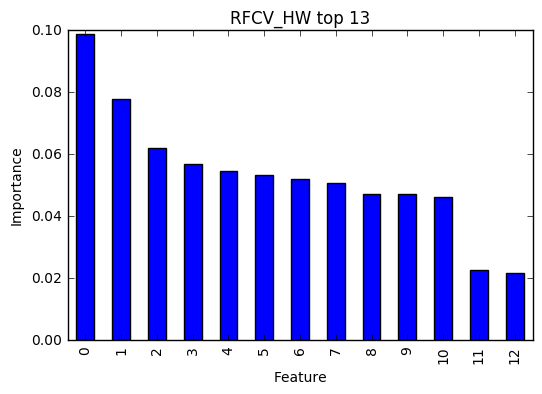

In [38]:
# Plot the feature importances of the forest
plt.figure()
plt.title("RFCV_HW top 13")
t_feature['feature_importance'].plot(kind='bar') 
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

The top 5 of most important features are the same: weightedIAT, weightedExp, age, victories, games. The feature importance propotion of these top 13 features are slightly higher: 0.69.